# B.4 - Geographic Location Classification

This notebook classifies goals into three geographic levels:
- **Country**: The country where the goal is located
- **City**: The city or region within the country
- **Other Map Location**: Specific landmarks or locations (e.g., "Statue of Liberty")

Detected classifications are map-searchable and suitable for visualization with Folium.

In [ ]:
import requests
import pickle
import yaml
import os
import google.generativeai as genai
from typing import List
import pandas as pd
import time
from tqdm import tqdm
import json
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

c:\Users\Besitzer\Desktop\M.Sc. Social Data Science\3. Semester\Social graphs and interactions\DayZero\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Network

First, we load the previous network version from Notebook B.3.

In [2]:
url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/Prior%20Network%20Versions/b3_network.pkl"
response = requests.get(url)
response.raise_for_status()

G = pickle.loads(response.content)

In [3]:
# show all node attribute names
print(next(iter(G.nodes(data=True)))[1].keys())

dict_keys(['title', 'description', 'wants_to_do', 'have_done', 'comments', 'tags', 'included_by_our_users', 'merged_goals', 'category', 'category_confidence', 'location', 'location_confidence', 'classification_reasoning', 'classified'])


## Configuration

We then load the API configuration and set parameters.

In [4]:
# Load configuration
with open('../Data/Classification Setup Data/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print(f"Using model: {config['api']['model']}")

# Load API key
GEMINI_API_KEY = config['api'].get('api_key', None)
if not GEMINI_API_KEY:
    GEMINI_API_KEY = os.getenv('GEMINI_API_KEY', None)
    
if not GEMINI_API_KEY:
    print("⚠️ WARNING: GEMINI_API_KEY not found!")
else:
    print("✓ API key loaded successfully")

# Processing options
MAX_NODES_TO_PROCESS = None  # Set to a number (e.g., 100) to test on subset, None for all nodes
START_FROM_NODE = 0
SAVE_PROGRESS_EVERY = 50
VERBOSE = True
SHOW_SAMPLE_CLASSIFICATIONS = 5

print(f"\n{'='*50}")
print(f"Nodes to process: {MAX_NODES_TO_PROCESS if MAX_NODES_TO_PROCESS else 'All'}")
print(f"Starting from node: {START_FROM_NODE}")
print(f"{'='*50}\n")

Using model: models/gemini-2.5-flash-lite
✓ API key loaded successfully

Nodes to process: All
Starting from node: 0



## Initialize Gemini API

Again, we initialize the API.

In [5]:
# Configure Gemini API
if GEMINI_API_KEY:
    genai.configure(api_key=GEMINI_API_KEY)
    
    generation_config = {
        "temperature": config['api']['temperature'],
        "top_p": config['api']['top_p'],
        "max_output_tokens": config['api']['max_tokens'],
    }
    
    # Only add JSON mode for models that support it (not Gemma)
    if 'gemma' not in config['api']['model'].lower():
        generation_config["response_mime_type"] = "application/json"
    
    model = genai.GenerativeModel(
        model_name=config['api']['model'],
        generation_config=generation_config,
    )
    
    print("Gemini model initialized successfully")
    if 'gemma' in config['api']['model'].lower():
        print("  Note: Using Gemma model - JSON extraction from text")
else:
    print("Cannot initialize model without API key")

Gemini model initialized successfully


## Geographic Classification Functions

Here, we define the classification function, including a prompt that defines the three location levels we would like to obtain.

In [6]:
def create_geographic_prompt_batch(goals_batch: List[tuple]) -> str:
    """
    Create a prompt for the LLM to classify multiple goals at once into country, city, and specific location.
    goals_batch: List of tuples (node_id, title)
    """
    goals_text = "\n".join([f"{i+1}. (ID: {node_id}) {title}" for i, (node_id, title) in enumerate(goals_batch)])
    
    prompt = f"""You are a geographic location classification expert. Analyze the following {len(goals_batch)} goals and extract all geographic information for EACH goal.

Goals to classify:
{goals_text}

For EACH goal, extract THREE levels of geographic information:

1. **country**: The country mentioned (use standardized country names that are searchable on maps, e.g., "United States", "France", "Japan")
2. **city**: The city or region mentioned (use standardized city names, e.g., "New York City", "Paris", "Tokyo")
3. **other_map_location**: Specific landmarks, venues, or locations (e.g., "Statue of Liberty", "Eiffel Tower", "Mount Fuji")

IMPORTANT RULES:
- Use ONLY real, map-searchable location names (not generic terms)
- Use standard naming conventions that mapping services can find
- If a level is not mentioned or cannot be determined, use null
- If only a country is mentioned (e.g., "Visit the USA"), provide only the country
- If only a city is mentioned, try to infer the country if obvious
- For landmarks, always try to provide country and city as well
- All location strings must be actual places that can be geocoded

Return your response as a JSON array with {len(goals_batch)} objects, one for each goal IN THE SAME ORDER as listed above.

EXACT format:
[
  {{"node_id": "ID from goal", "country": "Country Name or null", "city": "City Name or null", "other_map_location": "Specific Location or null", "confidence": 0.XX}},
  ...
]

The confidence value (0-1) represents how certain you are about the geographic extraction for each goal.
"""
    return prompt


def classify_goals_batch(nodes_batch: List[tuple], model) -> List[dict]:
    """
    Classify multiple goals at once into geographic components: country, city, other_map_location.
    nodes_batch: List of tuples (node_id, node_data)
    Returns: List of classification results
    """
    # Prepare batch data
    goals_batch = []
    results = []
    
    for node_id, node_data in nodes_batch:
        title = node_data.get('title', '')
        if not title:
            # Handle missing data immediately
            results.append({
                'node_id': node_id,
                'node_attributes': node_data,
                'classification': {
                    'country': None,
                    'city': None,
                    'other_map_location': None,
                    'confidence': 0.0
                },
                'error': None
            })
        else:
            goals_batch.append((node_id, title, node_data))
    
    if not goals_batch:
        return results
    
    # Create batch prompt
    batch_input = [(node_id, title) for node_id, title, _ in goals_batch]
    prompt = create_geographic_prompt_batch(batch_input)
    
    try:
        # Call API with batch
        response = model.generate_content(prompt)
        response_text = response.text.strip()
        
        # Parse JSON response
        try:
            classifications = json.loads(response_text)
        except json.JSONDecodeError:
            # Try to extract JSON array from markdown code blocks
            import re
            json_match = re.search(r'```(?:json)?\s*(\[.*?\])\s*```', response_text, re.DOTALL)
            if json_match:
                classifications = json.loads(json_match.group(1))
            else:
                # Try to find any JSON array in the text
                json_match = re.search(r'\[.*\]', response_text, re.DOTALL)
                if json_match:
                    classifications = json.loads(json_match.group(0))
                else:
                    raise ValueError(f"Could not extract JSON from response: {response_text[:200]}")
        
        # Match classifications to nodes
        for i, (node_id, title, node_data) in enumerate(goals_batch):
            if i < len(classifications):
                classification_data = classifications[i]
                
                # Convert "null" strings to None
                for key in ['country', 'city', 'other_map_location']:
                    if key in classification_data and classification_data[key] == "null":
                        classification_data[key] = None
                
                results.append({
                    'node_id': node_id,
                    'node_attributes': node_data,
                    'classification': classification_data,
                    'error': None
                })
            else:
                # Missing classification in response
                results.append({
                    'node_id': node_id,
                    'node_attributes': node_data,
                    'classification': None,
                    'error': 'Missing classification in batch response'
                })
    
    except Exception as e:
        # If batch fails, return errors for all
        for node_id, title, node_data in goals_batch:
            results.append({
                'node_id': node_id,
                'node_attributes': node_data,
                'classification': None,
                'error': str(e)
            })
    
    return results


def create_geographic_prompt(title: str) -> str:
    """
    Create a prompt for the LLM to classify a goal into country, city, and specific location.
    (Single goal version - kept for compatibility)
    """
    prompt = f"""You are a geographic location classification expert. Analyze the following goal and extract all geographic information.

Goal Title: {title}

Extract THREE levels of geographic information:

1. **country**: The country mentioned (use standardized country names that are searchable on maps, e.g., "United States", "France", "Japan")
2. **city**: The city or region mentioned (use standardized city names, e.g., "New York City", "Paris", "Tokyo")
3. **other_map_location**: Specific landmarks, venues, or locations (e.g., "Statue of Liberty", "Eiffel Tower", "Mount Fuji")

IMPORTANT RULES:
- Use ONLY real, map-searchable location names (not generic terms)
- Use standard naming conventions that mapping services can find
- If a level is not mentioned or cannot be determined, use null
- If only a country is mentioned (e.g., "Visit the USA"), provide only the country
- If only a city is mentioned, try to infer the country if obvious
- For landmarks, always try to provide country and city as well
- All location strings must be actual places that can be geocoded

Examples:
- "Visit the Statue of Liberty" → country: "United States", city: "New York City", other_map_location: "Statue of Liberty"
- "Travel to Japan" → country: "Japan", city: null, other_map_location: null
- "See the Eiffel Tower" → country: "France", city: "Paris", other_map_location: "Eiffel Tower"
- "Explore Tokyo" → country: "Japan", city: "Tokyo", other_map_location: null
- "Visit the USA" → country: "United States", city: null, other_map_location: null
- "Go to Central Park" → country: "United States", city: "New York City", other_map_location: "Central Park"

Return your response as JSON in this EXACT format:
{{"country": "Country Name or null", "city": "City Name or null", "other_map_location": "Specific Location or null", "confidence": 0.XX}}

The confidence value (0-1) represents how certain you are about the geographic extraction overall.
"""
    return prompt


def classify_goal_geographic(node_id: str, node_data: dict, model) -> dict:
    """
    Classify a single goal into geographic components: country, city, other_map_location.
    (Single goal version - kept for retry logic)
    """
    title = node_data.get('title', '')
    
    # Handle missing data
    if not title:
        return {
            'node_id': node_id,
            'node_attributes': node_data,
            'classification': {
                'country': None,
                'city': None,
                'other_map_location': None,
                'confidence': 0.0
            },
            'error': None
        }
    
    # Create prompt
    prompt = create_geographic_prompt(title)
    
    try:
        # Call API
        response = model.generate_content(prompt)
        response_text = response.text.strip()
        
        # Parse JSON response
        try:
            classification_data = json.loads(response_text)
        except json.JSONDecodeError:
            # Try to extract JSON from markdown code blocks
            import re
            json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', response_text, re.DOTALL)
            if json_match:
                classification_data = json.loads(json_match.group(1))
            else:
                # Try to find any JSON object in the text
                json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
                if json_match:
                    classification_data = json.loads(json_match.group(0))
                else:
                    raise ValueError(f"Could not extract JSON from response: {response_text[:200]}")
        
        # Convert "null" strings to None
        for key in ['country', 'city', 'other_map_location']:
            if key in classification_data and classification_data[key] == "null":
                classification_data[key] = None
        
        return {
            'node_id': node_id,
            'node_attributes': node_data,
            'classification': classification_data,
            'error': None
        }
    
    except Exception as e:
        return {
            'node_id': node_id,
            'node_attributes': node_data,
            'classification': None,
            'error': str(e)
        }


print("✓ Geographic classification functions defined")

✓ Geographic classification functions defined


## Test Classification

Test on a single node to verify everything works.

In [7]:
# Test on a single node
test_node = list(G.nodes(data=True))[0]
test_node_id, test_node_data = test_node

print("Testing geographic classification on a sample node...")
print(f"Node ID: {test_node_id}")
print(f"Title: {test_node_data.get('title', 'N/A')}")

# Run classification
test_result = classify_goal_geographic(
    node_id=test_node_id,
    node_data=test_node_data,
    model=model
)

print(f"\n{'='*50}")
print("Test Result:")
print(f"{'='*50}")
if test_result['error']:
    print(f"Error: {test_result['error']}")
else:
    print(f"Country: {test_result['classification']['country']}")
    print(f"City: {test_result['classification']['city']}")
    print(f"Other Map Location: {test_result['classification']['other_map_location']}")
    print(f"Confidence: {test_result['classification']['confidence']}")
print(f"{'='*50}\n")
print("✓ Test successful! You can now run the full classification pipeline.")

Testing geographic classification on a sample node...
Node ID: dQggEQQH
Title: Make ice cream from scratch

Test Result:
Country: None
City: None
Other Map Location: None
Confidence: 0.0

✓ Test successful! You can now run the full classification pipeline.

Test Result:
Country: None
City: None
Other Map Location: None
Confidence: 0.0

✓ Test successful! You can now run the full classification pipeline.


## Run Geographic Classification Pipeline

In the pipeline below, we process all nodes and classify them into country, city, and specific location. We again did obtain these classification already from an initial run and therefore did not run these cells again and the output is empty. In the cell after the "Retry Failed Classifications" section, we read in the existing classification output.

In [ ]:
# Initialize results storage
classification_results = []

# Get all nodes
all_nodes = list(G.nodes(data=True))
print(f"Total nodes in graph: {len(all_nodes)}")

# Determine which nodes to process
if MAX_NODES_TO_PROCESS:
    nodes_to_process = all_nodes[START_FROM_NODE:START_FROM_NODE + MAX_NODES_TO_PROCESS]
else:
    nodes_to_process = all_nodes[START_FROM_NODE:]

print(f"Processing {len(nodes_to_process)} nodes (starting from node {START_FROM_NODE})")

# Process in batches of 20
print("\nStarting geographic classification (BATCH MODE - 20 goals per request)...\n")
request_delay = config['rate_limit']['delay_between_requests']
BATCH_SIZE = 20

# Create batches
batches = [nodes_to_process[i:i + BATCH_SIZE] for i in range(0, len(nodes_to_process), BATCH_SIZE)]
print(f"Total batches to process: {len(batches)}\n")

for batch_idx, batch in enumerate(tqdm(batches, desc="Processing batches")):
    
    # Classify the batch
    batch_results = classify_goals_batch(batch, model)
    classification_results.extend(batch_results)
    
    # Show sample results from first batch
    if VERBOSE and batch_idx == 0:
        print(f"\n{'='*50}")
        print(f"Sample results from first batch:")
        print(f"{'='*50}")
        for i, result in enumerate(batch_results[:SHOW_SAMPLE_CLASSIFICATIONS]):
            print(f"\nSample {i + 1}:")
            print(f"  Node ID: {result['node_id']}")
            print(f"  Title: {result['node_attributes'].get('title', '')[:60]}...")
            if result['error']:
                print(f"  Error: {result['error']}")
            else:
                print(f"  Country: {result['classification']['country']}")
                print(f"  City: {result['classification']['city']}")
                print(f"  Other Location: {result['classification']['other_map_location']}")
                print(f"  Confidence: {result['classification']['confidence']}")
        print(f"{'='*50}\n")
    
    # Save progress periodically
    if SAVE_PROGRESS_EVERY and (batch_idx + 1) % (SAVE_PROGRESS_EVERY // BATCH_SIZE + 1) == 0:
        with open('geographic_classification_progress.json', 'w') as f:
            json.dump(classification_results, f, indent=2)
        if VERBOSE:
            print(f"\n✓ Progress saved at {len(classification_results)} nodes")
    
    # Rate limiting between batches
    time.sleep(request_delay)

print(f"\n{'='*50}")
print(f"✓ Geographic classification complete!")
print(f"Total processed: {len(classification_results)}")
print(f"Errors: {sum(1 for r in classification_results if r['error'])}")
print(f"Success rate: {(1 - sum(1 for r in classification_results if r['error']) / len(classification_results)) * 100:.1f}%")
print(f"{'='*50}")

## Retry Failed Classifications

Rerun this cell until all failed classifications are done.

In [ ]:
# Retry failed classifications in batches
failed_indices = [i for i, result in enumerate(classification_results) if result['error']]
print(f"Found {len(failed_indices)} failed classifications to retry")

if failed_indices:
    print("Retrying failed classifications in batches...")
    
    # Get request delay from config (in case pipeline wasn't run)
    request_delay = config['rate_limit']['delay_between_requests']
    RETRY_BATCH_SIZE = 20
    
    # Prepare failed nodes for batch retry
    failed_nodes = [(classification_results[idx]['node_id'], 
                     classification_results[idx]['node_attributes']) 
                    for idx in failed_indices]
    
    # Create batches
    retry_batches = [failed_nodes[i:i + RETRY_BATCH_SIZE] 
                     for i in range(0, len(failed_nodes), RETRY_BATCH_SIZE)]
    
    print(f"Retrying {len(failed_nodes)} goals in {len(retry_batches)} batches...")
    
    retry_results = []
    for batch in tqdm(retry_batches, desc="Retrying batches"):
        batch_results = classify_goals_batch(batch, model)
        retry_results.extend(batch_results)
        time.sleep(request_delay)
    
    # Update original results with retry results
    successful_retries = 0
    for idx, retry_result in zip(failed_indices, retry_results):
        if not retry_result['error']:
            classification_results[idx] = retry_result
            successful_retries += 1
    
    # Save updated results
    with open('geographic_classification_results.json', 'w') as f:
        json.dump(classification_results, f, indent=2)
    
    final_errors = sum(1 for r in classification_results if r['error'])
    print(f"\n{'='*50}")
    print(f"Retry complete!")
    print(f"Successfully fixed: {successful_retries} / {len(failed_indices)}")
    print(f"Remaining errors: {final_errors}")
    print(f"{'='*50}")
else:
    print("No failed classifications to retry.")

## Load Existing Classification Results

We already ran the classification and want to continue from saved results, so we run this cell instead of the classification pipeline above.

In [8]:
# Load existing classification results from file
progress_file = '../Data/Classification Results/geographic_classification_results.json'

if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        classification_results = json.load(f)
    
    print(f"Loaded {len(classification_results)} classification results from {progress_file}")
    print(f"\nResults summary:")
    print(f"  Total results: {len(classification_results)}")
    print(f"  Errors: {sum(1 for r in classification_results if r['error'])}")
    print(f"  Success rate: {(1 - sum(1 for r in classification_results if r['error']) / len(classification_results)) * 100:.1f}%")
    
    # Show sample results
    print(f"\n{'='*50}")
    print("Sample results:")
    print(f"{'='*50}")
    for i, result in enumerate(classification_results[:3]):
        print(f"\nSample {i + 1}:")
        print(f"  Node ID: {result['node_id']}")
        print(f"  Title: {result['node_attributes'].get('title', '')[:60]}...")
        if result['error']:
            print(f"  Error: {result['error']}")
        else:
            print(f"  Country: {result['classification']['country']}")
            print(f"  City: {result['classification']['city']}")
            print(f"  Other Location: {result['classification']['other_map_location']}")
            print(f"  Confidence: {result['classification']['confidence']}")
    print(f"{'='*50}\n")
else:
    print(f"File '{progress_file}' not found.")
    print("Please run the classification pipeline first or check the filename.")

Loaded 2880 classification results from ../Data/Classification Results/geographic_classification_results.json

Results summary:
  Total results: 2880
  Errors: 0
  Success rate: 100.0%

Sample results:

Sample 1:
  Node ID: dQggEQQH
  Title: Make ice cream from scratch...
  Country: None
  City: None
  Other Location: None
  Confidence: 0.0

Sample 2:
  Node ID: nnEnjr7O
  Title: Leave an inspirational note inside a book for someone to fin...
  Country: None
  City: None
  Other Location: None
  Confidence: 0.0

Sample 3:
  Node ID: nusyxQLs
  Title: Fly a kite...
  Country: None
  City: None
  Other Location: None
  Confidence: 0.0



## Export Results to Excel and JSON

We export our results into excel and json again to validate our classification.

In [9]:
# Prepare data for export
excel_data = []

for result in classification_results:
    row = {
        'node_id': result['node_id'],
        'title': result['node_attributes'].get('title', ''),
        'description': result['node_attributes'].get('description', ''),
        'error': result['error']
    }
    
    if result['classification'] and not result['error']:
        row['country'] = result['classification'].get('country', '')
        row['city'] = result['classification'].get('city', '')
        row['other_map_location'] = result['classification'].get('other_map_location', '')
        row['confidence'] = result['classification'].get('confidence', '')
    else:
        row['country'] = ''
        row['city'] = ''
        row['other_map_location'] = ''
        row['confidence'] = ''
    
    excel_data.append(row)

# Create DataFrame
df_results = pd.DataFrame(excel_data)

# Save to Excel
output_excel = f'../Data/Validation/geographic_classification_results.xlsx'

with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name='Geographic Classifications', index=False)
    
    # Get the worksheet and adjust column widths
    worksheet = writer.sheets['Geographic Classifications']
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = min(max_length + 2, 50)
        worksheet.column_dimensions[column_letter].width = adjusted_width

print(f"Excel file saved: {output_excel}")

# Save to JSON
output_json = f'../Data/Validation/geographic_classification_results.json'
with open(output_json, 'w') as f:
    json.dump(classification_results, f, indent=2)

print(f"JSON file saved: {output_json}")

# Display summary statistics
print(f"\n{'='*50}")
print("Geographic Classification Summary:")
print(f"{'='*50}")
print(f"Total goals: {len(df_results)}")
print(f"Errors: {df_results['error'].notna().sum()}")
print(f"\nGoals with country: {df_results['country'].notna().sum()}")
print(f"Goals with city: {df_results['city'].notna().sum()}")
print(f"Goals with specific location: {df_results['other_map_location'].notna().sum()}")

# Mean confidence
confidences = pd.to_numeric(df_results['confidence'], errors='coerce').dropna()
if not confidences.empty:
    print(f"\nMean confidence: {confidences.mean():.3f}")

print(f"\n{'='*50}")
print("Top 10 Countries:")
print(df_results['country'].value_counts().head(10))

print(f"\n{'='*50}")
print("Top 10 Cities:")
print(df_results['city'].value_counts().head(10))

print(f"\n{'='*50}")
print("Top 10 Specific Locations:")
print(df_results['other_map_location'].value_counts().head(10))
print(f"{'='*50}")

Excel file saved: ../Data/Validation/geographic_classification_results.xlsx
JSON file saved: ../Data/Validation/geographic_classification_results.json

Geographic Classification Summary:
Total goals: 2880
Errors: 0

Goals with country: 2432
Goals with city: 1723
Goals with specific location: 1878

Mean confidence: 0.829

Top 10 Countries:
United States     873
United Kingdom    209
Australia         112
Canada             90
Italy              58
Japan              54
France             53
Spain              46
China              44
Brazil             37
Name: country, dtype: int64

Top 10 Cities:
New York City      49
London             43
Paris              25
Los Angeles        17
Washington D.C.    16
Sydney             15
Barcelona          15
Melbourne          15
Chicago            14
Amsterdam          14
Name: city, dtype: int64

Top 10 Specific Locations:
Niagara Falls                4
Cedar Point                  3
Grand Canyon                 3
Central Park                 

## Helper Function: Geocoding

Here, we create a function to get coordinates for locations using a geocoding service. This step has been important for previously included visualizations of exact locations.

In [10]:
# Initialize geocoder
geolocator = Nominatim(user_agent="dayzero_goal_mapper")

def geocode_location(location_name, max_retries=3):
    """
    Get latitude and longitude for a location name.
    Returns (lat, lon) tuple or None if geocoding fails.
    """
    if not location_name or pd.isna(location_name) or location_name == '':
        return None
    
    for attempt in range(max_retries):
        try:
            location = geolocator.geocode(location_name, timeout=10)
            if location:
                return (location.latitude, location.longitude)
            return None
        except (GeocoderTimedOut, GeocoderServiceError) as e:
            if attempt < max_retries - 1:
                time.sleep(1)  # Wait before retry
                continue
            print(f"Geocoding failed for '{location_name}': {e}")
            return None
        except Exception as e:
            print(f"Unexpected error geocoding '{location_name}': {e}")
            return None
    
    return None

print("Geocoding function defined")

Geocoding function defined


## Geocode All Locations

Here, we get coordinates for countries, cities, and specific locations

In [11]:
# Preview top locations before geocoding
df_with_locations = df_results.copy()

print("="*60)
print("LOCATION OVERVIEW - Before Geocoding")
print("="*60)

# Top 10 Countries
print(f"\n📍 Top 10 Countries:")
print("-" * 40)
country_counts = df_with_locations['country'].value_counts()
for i, (country, count) in enumerate(country_counts.head(10).items(), 1):
    print(f"{i:2}. {country:30} - {count:4} goals")

# Top 10 Cities
print(f"\n🏙️  Top 10 Cities:")
print("-" * 40)
city_counts = df_with_locations['city'].value_counts()
for i, (city, count) in enumerate(city_counts.head(10).items(), 1):
    print(f"{i:2}. {city:30} - {count:4} goals")

# Top 10 Specific Locations
print(f"\n🎯 Top 10 Specific Locations:")
print("-" * 40)
location_counts = df_with_locations['other_map_location'].value_counts()
for i, (location, count) in enumerate(location_counts.head(10).items(), 1):
    print(f"{i:2}. {location:30} - {count:4} goals")

print(f"\n" + "="*60)
print(f"Total unique countries: {len(country_counts)}")
print(f"Total unique cities: {len(city_counts)}")
print(f"Total unique locations: {len(location_counts)}")
print("="*60)

LOCATION OVERVIEW - Before Geocoding

📍 Top 10 Countries:
----------------------------------------
 1. United States                  -  873 goals
 2. United Kingdom                 -  209 goals
 3. Australia                      -  112 goals
 4. Canada                         -   90 goals
 5. Italy                          -   58 goals
 6. Japan                          -   54 goals
 7. France                         -   53 goals
 8. Spain                          -   46 goals
 9. China                          -   44 goals
10. Brazil                         -   37 goals

🏙️  Top 10 Cities:
----------------------------------------
 1. New York City                  -   49 goals
 2. London                         -   43 goals
 3. Paris                          -   25 goals
 4. Los Angeles                    -   17 goals
 5. Washington D.C.                -   16 goals
 6. Sydney                         -   15 goals
 7. Barcelona                      -   15 goals
 8. Melbourne           

We geocode the locations in the subsequent cell. Again, we already performed this process so we just read the already created file in afterwards.

In [ ]:
# Filter out empty/null values
df_with_locations = df_results.copy()

# Geocode countries
print("Geocoding countries...")
unique_countries = df_with_locations['country'].dropna().unique()
country_coords = {}

for country in tqdm(unique_countries, desc="Geocoding countries"):
    if country and country != '':
        coords = geocode_location(country)
        if coords:
            country_coords[country] = coords
        time.sleep(0.5)  # Rate limiting for Nominatim

print(f"Successfully geocoded {len(country_coords)} out of {len(unique_countries)} countries")

# Geocode cities (with country context for better accuracy)
print("\nGeocoding cities...")
unique_cities = df_with_locations[['city', 'country']].dropna().drop_duplicates()
city_coords = {}

for _, row in tqdm(unique_cities.iterrows(), total=len(unique_cities), desc="Geocoding cities"):
    city = row['city']
    country = row['country']
    if city and city != '':
        # Add country for better accuracy
        search_query = f"{city}, {country}" if country and country != '' else city
        coords = geocode_location(search_query)
        if coords:
            city_coords[city] = coords
        time.sleep(0.5)  # Rate limiting

print(f"Successfully geocoded {len(city_coords)} out of {len(unique_cities)} cities")

# Geocode specific locations (with city and country context)
print("\nGeocoding specific locations...")
unique_locations = df_with_locations[['other_map_location', 'city', 'country']].dropna(subset=['other_map_location']).drop_duplicates()
location_coords = {}

for _, row in tqdm(unique_locations.iterrows(), total=len(unique_locations), desc="Geocoding specific locations"):
    location = row['other_map_location']
    city = row['city']
    country = row['country']
    
    if location and location != '':
        # Build search query with context
        parts = [location]
        if city and city != '':
            parts.append(city)
        if country and country != '':
            parts.append(country)
        search_query = ", ".join(parts)
        
        coords = geocode_location(search_query)
        if coords:
            location_coords[location] = coords
        time.sleep(0.5)  # Rate limiting

print(f"Successfully geocoded {len(location_coords)} out of {len(unique_locations)} specific locations")

# Save geocoded data
geocode_data = {
    'countries': country_coords,
    'cities': city_coords,
    'locations': location_coords
}

with open('geocoded_locations.json', 'w') as f:
    json.dump(geocode_data, f, indent=2)

print(f"\nGeocoded data saved to geocoded_locations.json")

# Read in Data

Reading in the previous classification data again.

In [12]:
# Load precomputed geocoded locations from requested path
geocode_path = os.path.join('..', 'Data', 'Classification Results', 'geocoded_locations.json')
if os.path.exists(geocode_path):
    try:
        with open(geocode_path, 'r', encoding='utf-8') as f:
            geocode_data = json.load(f)
        print(f'Loaded geocoded data from: {geocode_path}')
    except Exception as e:
        print(f'Error loading {geocode_path}: {e}')
        geocode_data = None
else:
    geocode_data = None
    print(f'No geocoded_locations.json found at: {geocode_path}')

if geocode_data is None:
    country_coords = {}
    city_coords = {}
    location_coords = {}
    print('Defined empty geocode containers (country_coords, city_coords, location_coords).')
else:
    country_coords = geocode_data.get('countries', {})
    city_coords = geocode_data.get('cities', {})
    location_coords = geocode_data.get('locations', {})
    print(f"Countries: {len(country_coords)}, Cities: {len(city_coords)}, Specific locations: {len(location_coords)}")

Loaded geocoded data from: ..\Data\Classification Results\geocoded_locations.json
Countries: 181, Cities: 965, Specific locations: 1349


## Country Choropleth Map - Total Goal Mentions

Here we visualize total goal mentions by country using colored country shapes (choropleth map).


Total countries with goal mentions: 181
Total goals with country information: 2432

Goal count range: 1 to 873


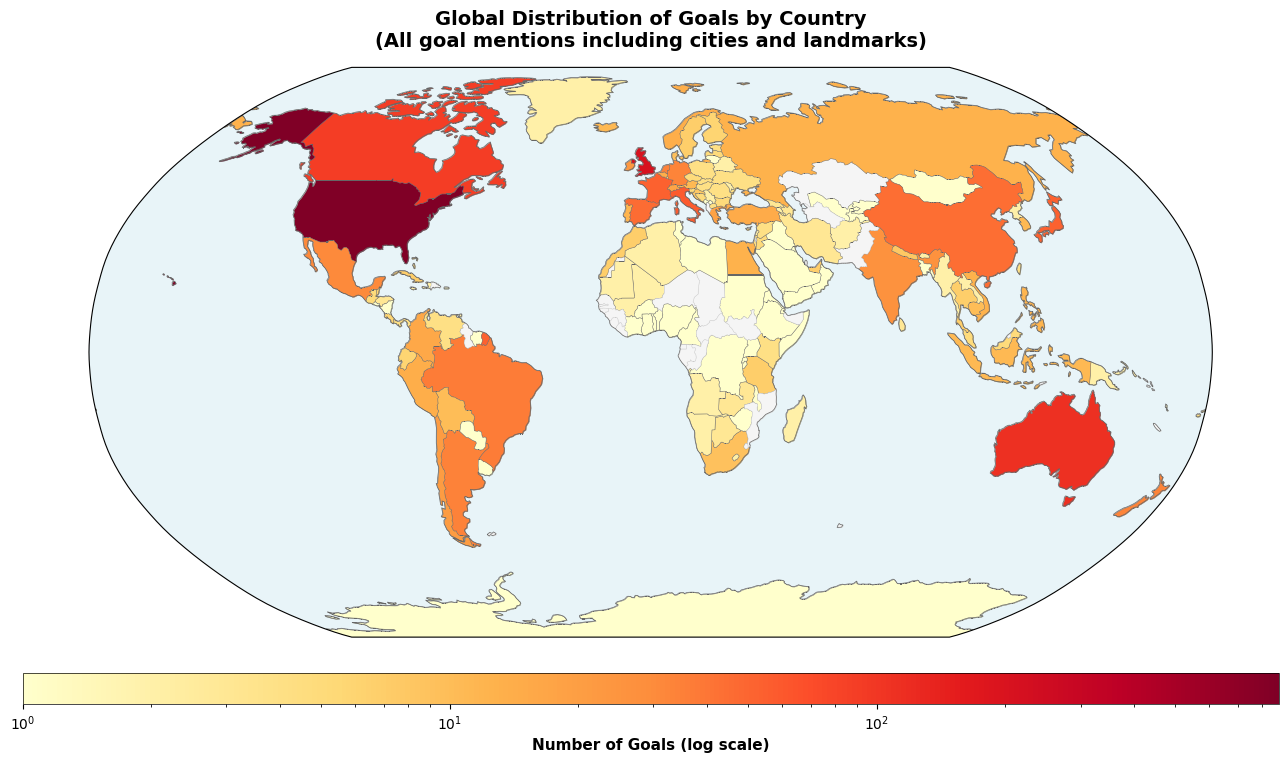

In [13]:
# Create choropleth map - countries colored by total goal mentions

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Add ocean and set global extent
ax.add_feature(cfeature.OCEAN, facecolor='#e8f4f8', zorder=0)
ax.set_global()

# Get country shapes from Natural Earth
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# Create a mapping of country names to goal counts
# We need to handle different country name formats
country_name_mapping = {
    'United States': 'United States of America',
    'United States of America': 'United States of America',
    'USA': 'United States of America',
    'UK': 'United Kingdom',
    'England': 'United Kingdom',
    'Scotland': 'United Kingdom',
    'Wales': 'United Kingdom',
    'Northern Ireland': 'United Kingdom',
    'Czech Republic': 'Czechia',
    'South Korea': 'South Korea',
    'North Korea': 'North Korea',
    'Republic of Korea': 'South Korea',
    'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Congo': 'Congo',
    'Tanzania': 'Tanzania',
    'Serbia': 'Serbia',
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
}

# Calculate total country counts (all goals mentioning each country)
total_country_counts = df_results['country'].value_counts()

print(f"\nTotal countries with goal mentions: {len(total_country_counts)}")
print(f"Total goals with country information: {total_country_counts.sum()}")

# Normalize country names and create mapping
country_goal_map = {}
for country, count in total_country_counts.items():
    if country:
        # Use mapping if available, otherwise use original name
        mapped_name = country_name_mapping.get(country, country)
        if mapped_name in country_goal_map:
            country_goal_map[mapped_name] += count
        else:
            country_goal_map[mapped_name] = count

# Get min and max for color scaling
if country_goal_map:
    max_goals = max(country_goal_map.values())
    min_goals = min(country_goal_map.values())
    
    # Use log scale for better color distribution
    from matplotlib.colors import LogNorm
    norm = LogNorm(vmin=max(1, min_goals), vmax=max_goals)
    cmap = plt.cm.YlOrRd
    
    print(f"\nGoal count range: {min_goals} to {max_goals}")
    
    # Draw each country
    for country in shpreader.Reader(countries_shp).records():
        country_name = country.attributes['NAME']
        
        # Get goal count for this country
        goal_count = country_goal_map.get(country_name, 0)
        
        if goal_count > 0:
            # Color based on goal count
            color = cmap(norm(goal_count))
            ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                            facecolor=color, 
                            edgecolor='#666666', 
                            linewidth=0.3,
                            zorder=1)
        else:
            # Countries with no goals - light gray
            ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                            facecolor='#f5f5f5', 
                            edgecolor='#cccccc', 
                            linewidth=0.3,
                            zorder=1)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal',
                       pad=0.05, aspect=40, shrink=0.8)
    cbar.set_label('Number of Goals (log scale)', fontsize=11, weight='bold')
    cbar.outline.set_linewidth(0.5)
    
    # Add coastlines for clarity
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='#666666', zorder=2)
    
    ax.set_title('Global Distribution of Goals by Country\n(All goal mentions including cities and landmarks)', 
                fontsize=14, weight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()

# Network Creation, Filtering, and Export Final Network Version

First, we add all geo classification data to our previous network from B.3.

In [14]:
# Create a mapping from node_id to geographic attributes
geo_mapping = {}
for result in classification_results:
    node_id = result['node_id']
    
    if result['classification'] and not result['error']:
        geo_mapping[node_id] = {
            'country': result['classification'].get('country', None),
            'city': result['classification'].get('city', None),
            'other_map_location': result['classification'].get('other_map_location', None),
            'geo_confidence': result['classification'].get('confidence', None)
        }
    else:
        geo_mapping[node_id] = {
            'country': None,
            'city': None,
            'other_map_location': None,
            'geo_confidence': None
        }

# Add geographic attributes to network nodes
print("\nAdding geographic attributes to nodes...")
nodes_updated = 0
for node_id in G.nodes():
    if node_id in geo_mapping:
        G.nodes[node_id]['country'] = geo_mapping[node_id]['country']
        G.nodes[node_id]['city'] = geo_mapping[node_id]['city']
        G.nodes[node_id]['other_map_location'] = geo_mapping[node_id]['other_map_location']
        G.nodes[node_id]['geo_confidence'] = geo_mapping[node_id]['geo_confidence']
        nodes_updated += 1

print(f"Updated {nodes_updated} nodes with geographic attributes")


Adding geographic attributes to nodes...
Updated 2880 nodes with geographic attributes


Now, we remove all variables that we will not focus on in the subsequent analysis stage.

In [15]:
# show all node attribute names
print(next(iter(G.nodes(data=True)))[1].keys())

dict_keys(['title', 'description', 'wants_to_do', 'have_done', 'comments', 'tags', 'included_by_our_users', 'merged_goals', 'category', 'category_confidence', 'location', 'location_confidence', 'classification_reasoning', 'classified', 'country', 'city', 'other_map_location', 'geo_confidence'])


In [16]:
attrs_to_remove = ["category_confidence", "classification_error", "classification_reasoning", "classified", "geo_confidence", "location", "location_confidence", "merged_goals"]

for n, data in G.nodes(data=True):
    for attr in attrs_to_remove:
        data.pop(attr, None)

All remaining node attributes for our final network:

In [17]:
# show all node attribute names
print(next(iter(G.nodes(data=True)))[1].keys())

dict_keys(['title', 'description', 'wants_to_do', 'have_done', 'comments', 'tags', 'included_by_our_users', 'category', 'country', 'city', 'other_map_location'])


Finally, we export our final network to the Networks folder.

In [18]:
# Now save to pickle file
with open("../Networks/dayzero_network.pkl", "wb") as f:
    pickle.dump(G, f)